# Implementing a Paper

I want to provide some tips from my experience implementing a paper. I'm going to cover my tips so far from implementing a dramatically scaled-down version of [Llama](https://arxiv.org/pdf/2302.13971.pdf) for training [TinyShakespeare](https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt). This post is heavily inspired by Karpathy's [Makemore series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ), which I highly recommend.

I'm only going to *loosely* follow the layout of their paper; while the formatting and order of sections makes sense for publication, we're going to be implementing the paper. I'll also be skipping over some of the more obvious steps, like setting up a virtual environment and installing dependencies.

## About Llama

Llama is a transformer-based model for language modeling. Meta AI [open-sourced](https://github.com/facebookresearch/llama) Llama this summer, and it's gained a lot of attention (pun intended). When you're reading the introduction, they clearly indicate their goal: make a model that's cheaper for running inference, rather than optimizing training costs. 

At this point, we'll just load our libraries and get started.

In [61]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

## Setting up our dataset
While in Llama they train on 1.4T tokens, our dataset TinyShakespeare, the collection of all of Shakespeare's works, is about 1M characters.

In [62]:
lines = open('./input.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

They use the [SentencePiece](https://github.com/google/sentencepiece) byte-pair encoding tokenizer, but we're going to just use a simple character-level tokenizer.

In [63]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

Since our dataset is small enough, we don't need to worry about how we store it in memory etc.

In [64]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])

First tip: I'm creating a `config` object that stores some basic model params. It makes our code way more readable and removes constants and magic numbers from the code. I'm not going to use types, as  I want to keep things flexible for now and be able to add more parameters later on.

In [65]:
config = {
    "vocab_size": len(vocab),
    'batch_size': 10,
    'context_window': 10,
}

Let's create a method to generate our training data and labels for batches. We'll use the same method for validation and test data. Note that I like to test my functions in the same block that I define them, just to make sure they work as expected before moving on.

In [66]:
def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('e can both', ' can both '),
 ('\nThe purpl', 'The purple'),
 ('And never ', 'nd never w'),
 ('fence.\n\nME', 'ence.\n\nMEN'),
 ('SET:\nMy lo', 'ET:\nMy lor'),
 ('ey would h', 'y would ha'),
 ('!--\nThe mo', '--\nThe mou'),
 ('oke freely', 'ke freely '),
 ('fore?\nI pr', 'ore?\nI pri'),
 ("ale's best", "le's best ")]

What's interesting about implementing papers is that there are two aspects to the model *working*: compilation (do your tensors all match up from layer to layer), and training (does the loss go down). Figuring out how to ensure that each of your compoenents is working is key to developing your model in a predictable, engineering-minded way.

> Tip 2: start with something you know compiles and trains, then swap out components iteratively. Otherwise, you're going to be crossing your fingers hoping your model trains without knowing why it doesn't. 

That's why we're also going to define the method for how we're going to evaluate the model. We want to do this before we even define the model, because we want to be able to use it to evaluate the model as we're training it. 

In [67]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

## Setting up a working base model

Here's a basic feed-forward neural network with embeddings. It's the base model we're going to start with, and then swap out parts of it as we go along until we eventually end up with the model as described in Llama.

In [68]:
config = {
    'vocab_size': len(vocab),
    'd_model': 512, # the size of the embedding vector
    'batch_size': 128,
    'context_window': 8,
}

class SimpleBrokenModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        logits = F.softmax(a, dim=-1)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleBrokenModel(config)
xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

logits, loss = model(xs, ys)

model params: 329281


It's at this point that we have to start worrying about the shape of our tensors and making indices match. Check out this line of our model definition:

```python
loss = F.cross_entropy(logits.view(-1, config['vocab_size']), targets.view(-1))
```

We have to reshape the `logits` and `targets` tensors so that their dimensions match when we compare. We do this with the `view` method. The `-1` argument means "infer this dimension from the others". So, in this case, we're saying "reshape `logits` and `targets` to have the same number of rows, and however many columns are needed to make that happen". This is a common pattern when you're working with batches of data.

> Tip 3: Use `.shape` religiously to always know what shape your tensors are.

Alright, let's train our `SimpleBrokenModel` to make sure gradients flow. After we confirm that, we can swap out parts of it to match Llama, train again, and track our progress. It's at this point that I start keeping a *log* of my training runs, so that I can easily just go back to a previous run in the event that I mess something up.

model params: 33217
validation loss:  3.949686145782471


<Axes: >

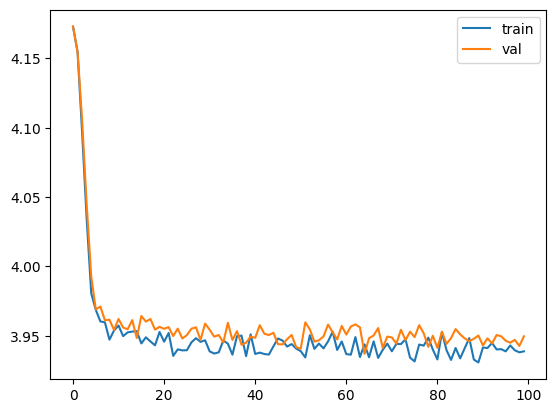

In [69]:
config = {
    "d_model": 128,
    "batch_size": 32,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 1000,
    "log_interval": 10,
}
model = SimpleBrokenModel(config)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

def train(model, optimizer, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()
        
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

Notice how we get a training curve that goes down, but barely by anything. How do we know it's barely training? We have to use first principles. The cross-entropy loss before training is 4.17, and after 1000 epochs is 3.93. How can we make sense of it intuitively?

Cross-entropy in this context is referring to how likely we are to pick the wrong word. So here,

$$
H(T, q) = - \sum_{i = 1}^{N} \frac{1}{N} \log q(x_i)
$$

where $q(x_i)$ is the probability of picking the right word, as estimated by the model. If $q(x_i)$ is close to 1, then $\log q$ is close to 0; similarly, if $q$ is small, then $\log q$ is a large negative number, so $-\log q$ will be a large positive number. Now to build the intuition: to start, $-\log q = 4.17$, so $q = 0.015$, or around $\frac{1}{64.715}$. Recall that the vocabulary size $|V| = 65$, so what we're basically saying here is that the model is as good at choosing the next letter as randomly picking from our vocabulary. After training, $-\log q = 3.93$, so we're now basically choosing between 50 letters. This is a very small improvement, so something is probably wrong.

Let's try to debug what's going on. Notice that in our model we're using a softmax layer on our logits, which is a function that takes a vector of numbers and squashes them into a probability distribution. But for using the built in `F.cross_entropy` function, we need to pass in the [unnormalized logits directly](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). So let's remove that from our model and try again.

model params: 33217
validation loss:  2.469549775123596


<Axes: >

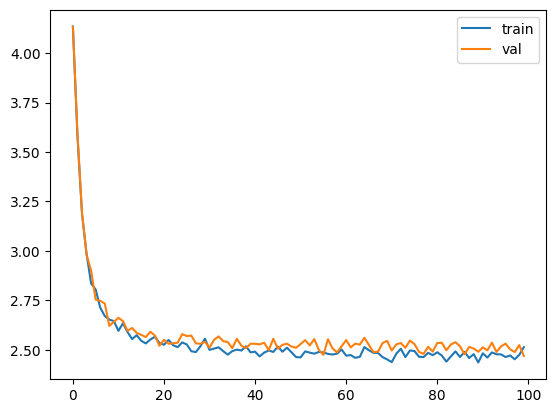

In [204]:
config = {
    "d_model": 128,
    "batch_size": 32,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 1000,
    "log_interval": 10,
}

class SimpleModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel(config)
xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Great, now our loss is $2.54$, so we're choosing from $12.67$ characters. That's way better than the 65 we started with. Let's add a generate method to our model so we visually see the results of our model.

In [ ]:
def generate(model, config, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

generate(model, config, 50)

['\nGn, my,\n\nhious ceaw.\nRY f od lle idwn ird, s!\nMart',
 '\nMENUD and K:\nMAnon orend fanou Frend qu ome isad b',
 '\nShourd tour peerthoude\nment hin ad end t man menn ',
 '\nIIf m hele, wid, ike coour t meajesengour f cer wi',
 '\nUCle.\nCHigis:\nI: s f Yar bimpalfe, d wes t y f t t']

It's not half bad, but also not half good. But now we have a working model that is training to a validation loss. So here we'll iterate on our model to make it closer to Llama.

## Llama specifics
Llama describes three architectural modifications to the original Transformer:
1. Pre-normalization
2. SwiGLU activation function
3. Rotary embeddings

We're going to add each one, one at a time to our base model, and iterate.

### Rotary Embeddings
[RoPE](https://arxiv.org/pdf/2104.09864.pdf) is a kind of positional encoding for transformers. In Attention is All You Need, the authors propose two kinds of positional encodings, learned and fixed. In RoPE, the authors propose embedding the position of a token in a sequence by rotating the embedding, with a different rotation at each position.

### RMSNorm

In Vaswani 2017, the original transformer uses BatchNormalization. In Llama, the authors use RMSNorm, which is where you scale the bector by the variance without centering it. In addition, while Vaswani applies normalization to the output of the attention layer (post-normalization), Llama applies it to the inputs before (pre-normalization).

In [440]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        self.scale = nn.Parameter(torch.ones(layer_shape))
        self.register_parameter("scale", self.scale)

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'],config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


We want to test to ensure that the RMSNorm is doing what we think it should. We can do this the old-fashioned way: row-wise comparisons. The RMSNorm has the property where the norm of the layer will be the square root of the number of elements in the layer, so we can check that for every layer.

In [411]:
rms = torch.linalg.norm(batch, dim=(1,2)) * (batch[0].numel() ** -.5)

# scaled_batch.var(dim=(1,2))
assert torch.linalg.norm( torch.arange(5).float() ) == (torch.arange(5).float() ** 2 ).sum() ** .5
rms = torch.linalg.norm( torch.arange(5).float() ) * (torch.arange(5).numel() ** -.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -.5

# RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]
assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)

Alright, so that's RMSNorm, and it seems like it's working. Again, let's test it out.

model params: 35265
validation loss:  2.490482950210571


<Axes: >

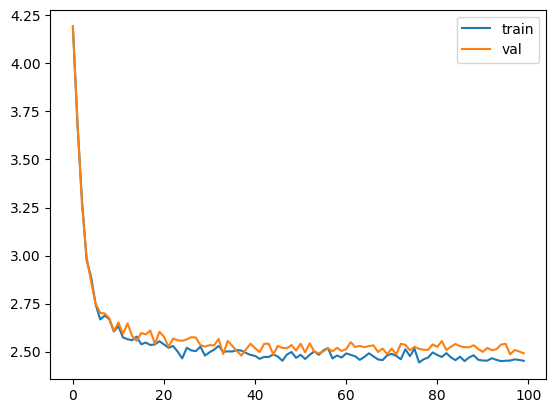

In [442]:
config = {
    "d_model": 128,
    "batch_size": 32,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 1000,
    "log_interval": 10,
}

class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel_RMS(config)
xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

So RMSNorm works. Nice.

### RoPE Rotation

Now let's implement RoPEAttention. RoPE was first proposed in [RoFormer](https://arxiv.org/pdf/2104.09864.pdf), basically adds positional information to embeddings by rotating them in a different way depending on their position. The rotations are fixed, not learned, and exhibit some ideal properties that we want to preserve.

In [555]:
def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

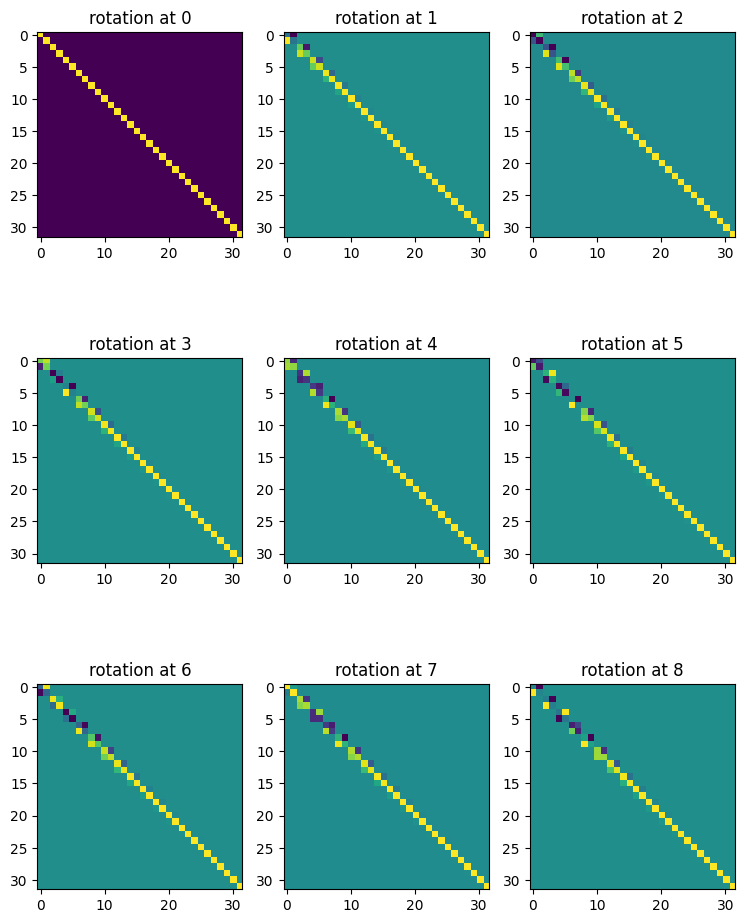

In [556]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

Let's make sure these work. They should exhibit the quality that 
$$
q_m^T k_n = (R^d_{\Theta, m}W_q x_m)^T (R^d_{\Theta, n} W_k x_n) = x^T W_q R^d_{\Theta, n-m} W_k x_n.
$$

In [558]:
config = {
    'd_model': 512,
    'context_window': 16,
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m,:,:] @ y)

So the RoPE rotations work as expected.

In [593]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_out = (torch.bmm(q.transpose(0,1), self.R)).transpose(0,1)
        k_out = (torch.bmm(k.transpose(0,1), self.R)).transpose(0,1)
        v_out = (torch.bmm(v.transpose(0,1), self.R)).transpose(0,1)

        causal_mask = torch.tril(torch.ones(m,m, requires_grad=False))
        activations, attn_weights = self.multihead(
            q,k,v, 
            attn_mask=causal_mask,
            is_causal=True
        )

        if return_attn_weights:
            return activations, attn_weights
        return activations

layer = RoPEAttention(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

Let's make sure it does what we think it does. For this layer, we're going to want to test three things:
1. that it rotates embeddings the way we think it does 
2. that the attention mask used for causal attention is working properly.

In [595]:
x = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

q = layer.w_q(x)
k = layer.w_k(x)
v = layer.w_v(x)

q_rotated = torch.zeros_like(x)
k_rotated = torch.zeros_like(x)
v_rotated = torch.zeros_like(x)

for position in range(config['context_window']):
    q_rotated[:,position,:] = torch.matmul(q[:,position,:], layer.R[position,:,:])
    k_rotated[:,position,:] = torch.matmul(k[:,position,:], layer.R[position,:,:])
    v_rotated[:,position,:] = torch.matmul(v[:,position,:], layer.R[position,:,:])

q_out = (torch.bmm(q.transpose(0,1), layer.R)).transpose(0,1)
k_out = (torch.bmm(k.transpose(0,1), layer.R)).transpose(0,1)
v_out = (torch.bmm(v.transpose(0,1), layer.R)).transpose(0,1)

assert torch.allclose(q.transpose(0,1)[0], q[:,0,:])
assert torch.allclose(q.transpose(0,1)[0] @ layer.R[0], q[:,0,:] @ layer.R[0])
assert torch.allclose(q_rotated, q_out)

In [634]:
config = {
    'batch_size': 1,
    'd_model': 2,
    'n_heads': 2,
    'context_window': 3,
}

layer = RoPEAttention(config)
batch = torch.ones((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

m = 0
x_q = batch[0, m]
q = layer.R[m,:,:] @ layer.w_q(x_q)

assert torch.allclose(layer.w_q(x_q), layer.w_q.weight @ x_q)
assert torch.allclose(q, layer.R[m, :, :] @ layer.w_q.weight @ x_q)

n = 2
x_k = batch[0, n]
k = layer.R[n,:,:] @ layer.w_k(x_k)

assert torch.allclose(layer.w_k(x_k), layer.w_k.weight @ x_k)
assert torch.allclose(k, layer.R[n, :, :] @ layer.w_k.weight @ x_k)

assert q.T @ k == q @ k # transpose is redundant
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n, :, :].T @ layer.R[m, :, :] @ layer.w_q.weight @ x_q)
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n-m, :, :].T @ layer.w_q.weight @ x_q)

In [ ]:
config = {
    "d_model": 128,
    "batch_size": 32,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 1000,
    "log_interval": 10,
}

class RoPEModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RoPEModel(config)
xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

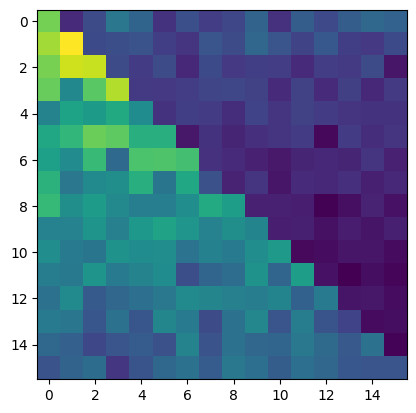

In [390]:
plt.imshow(attn_weights[0].detach().numpy())

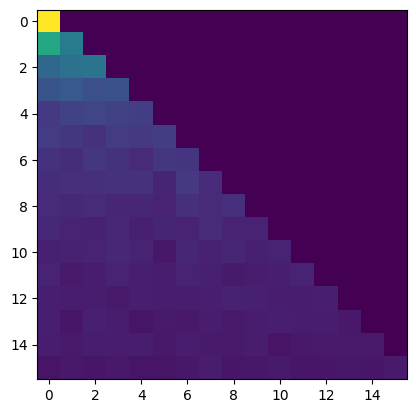

In [391]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'])
        self.w_k = nn.Linear(config['d_model'], config['d_model'])
        self.w_v = nn.Linear(config['d_model'], config['d_model'])

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.rms = RMSNorm((config['batch_size'], config['context_window'], config['d_model']))

    def get_rotary_matrix(self, x):
        b, m, d = x.shape
        R = torch.zeros((d, d, m), requires_grad=False)
        for position in range(m):
            for i in range(d//2):
                theta = 10000. ** (-2.*(i - 1) / d)
                m_theta = position * theta
                R[2*i,2*i, position] = np.cos(m_theta)
                R[2*i,2*i+1, position] = - np.sin(m_theta)
                R[2*i+1,2*i, position] = np.sin(m_theta)
                R[2*i+1,2*i+1, position] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        x = self.rms(x)

        R = self.get_rotary_matrix(x)
        x_rotated = torch.zeros_like(x)
        for position in range(m):
            x_rotated[:,position,:] = torch.matmul(x[:,position,:], R[:,:,position])

        q = self.w_q(x_rotated)
        k = self.w_k(x_rotated)
        v = self.w_v(x_rotated)

        activations, attn_weights = self.multihead(
            q,k,v, 
            attn_mask=nn.Transformer.generate_square_subsequent_mask(m),
            is_causal=True
        )
        if return_attn_weights:
            return x + activations, attn_weights
        return x + activations

m = RoPEAttention(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

outputs, attention_weights = m(batch, return_attn_weights=True)
plt.imshow(attention_weights[0].detach().numpy())

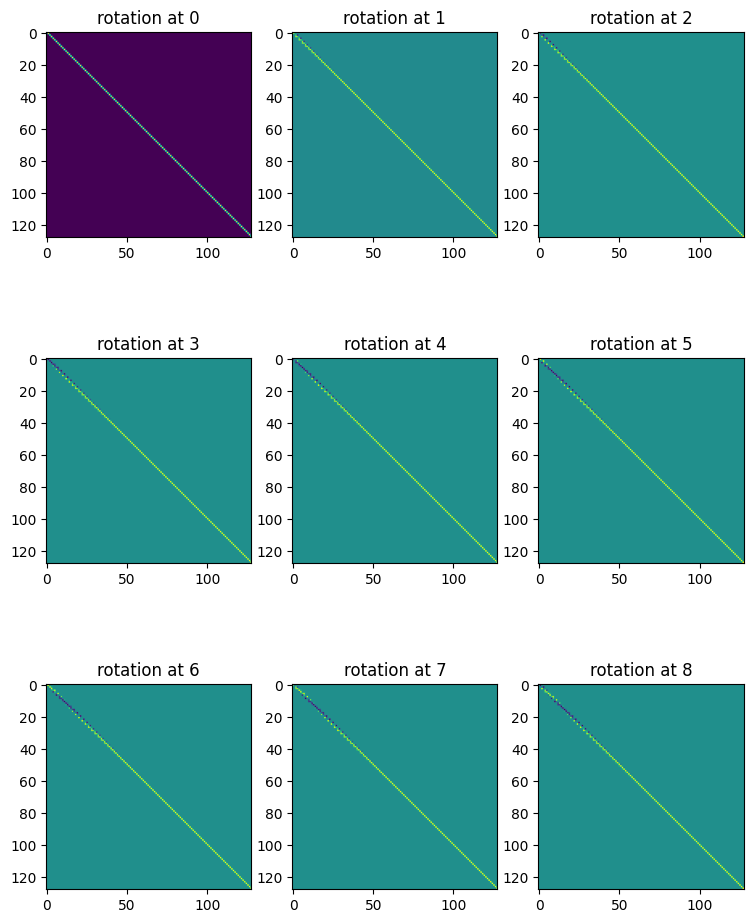

In [71]:
config = {
    "n_heads": 8,
    "d_model": 128,
}
m = LlamaAttentionLayer(config)
K = 3
batch = torch.randn(1, K**2, config['d_model'])
R = m.get_rotary_matrix(batch)
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[:, :, i * K + j].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

In [ ]:
config = {
    "n_heads": 8,
    "d_model": 128,
}
m = LlamaAttentionLayer(config)
batch = torch.randn(1, 10, config['d_model'])
activations, attn_weights = m(batch, return_attn_weights=True)
plt.imshow(attn_weights.detach().numpy()[0])
plt.colorbar()

attn_weights.squeeze(0).sum(dim=0)

NameError: name 'RMSNorm' is not defined

### SwiGLU

As it says in the paper, "We replace the ReLU non-linearity by the SwiGLU activation function...we use a dimension of $\frac{2}{3} 4d$ isntead of $4d$ as in PaLM." SwiGLU is defined as:
$$ 
\text{SwiGLU}(x) = \text{Swish}_\beta (xW + b) \otimes (xV + c)
$$
where $\otimes$ is a component-wise product. The Swish function is defined as:
$$
\text{Swish}_\beta(x) = x \sigma(\beta x)
$$
where $\beta$ is a learnable parameter.

In [49]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

model params: 33217
validation loss:  2.4846662521362304


<Axes: >

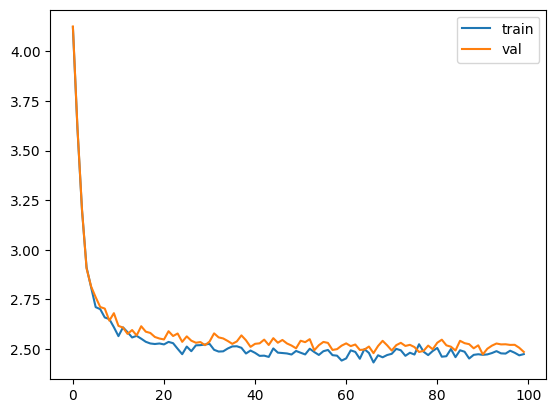

In [50]:
config = {
    "d_model": 128,
    "batch_size": 32,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 1000,
    "log_interval": 10,
}

class SimpleSwiGLUModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(configp['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel(config)
xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [517]:
# add RMSNorm and residual conncection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.attention = LlamaAttentionLayer(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )
        self.rms = RMSNorm(config['d_model'])
    
    def forward(self, x):
        attended = self.attention(x)
        out = attended + self.feedforward(self.rms(attended))
        return out
    
config = {
    "n_heads": 8,
    "d_model": 128,
}
m = LlamaBlock(config)
batch = torch.randn(1, 10, config['d_model'])
m(batch).shape

IndexError: too many indices for tensor of dimension 1

In [98]:
from collections import OrderedDict

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits
        
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
    def generate(self, idx, max_new_tokens=20):
        for _ in range(max_new_tokens):
            # call the model
            logits = self(idx[:, -config['context_window']:])
            last_time_step_logits = logits[
                :, -1, :
            ]  # all the batches (1), last time step, all the logits
            p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
            idx_next = torch.multinomial(
                p, num_samples=1
            )  # sample from the distribution to get the next token
            idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
        return idx
            
config = {
    "n_heads": 1,
    "d_model": 128,
    "batch_size": 32,
    "n_layers": 1,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 1000,
    "log_interval": 50,
}
m = Llama(config)
xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
m(xs, targets=ys)

print(f"n params: {sum([p.numel() for p in m.parameters() if p.requires_grad])}")

[decode(x) for x in m.generate(torch.zeros(5, 1).long()).tolist()]

n params: 231617


['\naWuP?UvG!:KoUDOP!sXd',
 '\nTjnVxklFnYRQfMPy,hL3',
 '\nJAieX$QcALCEj:\nG Hps',
 '\nales;HhEx!IX3NCvgTCL',
 "\nCsfnG\n P.co?NDriy&.'"]

Epoch 0 | val loss 4.158 | Time 0.150 | ETA in seconds 6.010
['\nOBACn;hX,ZzhvaVfrXX ', '\nt;Jspqth ;bum;GiUIML', '\ni\nwwUKLtZevyJilwGxWy', '\nX,MwFtLR3bS-JdKN!Br!', "\n!'UN3?ma;H& OyN-fxFD"]
Epoch 50 | val loss 2.695 | Time 8.062 | ETA in seconds 314.418
['\nALches sebrongople s', '\nme o to frlpeer avou', '\nlowh ade ouplurnd me', '\nSKwnge ss onlirwaI o', '\n\nMod toutrienn winty']
Epoch 100 | val loss 2.513 | Time 8.072 | ETA in seconds 306.745
['\nALld, re bold maprum', "\nUNAcIUNAen'l\n\nd y se", '\n\nTle Lot, sug hor; c', '\nO!INI:\nNIC:\nOUTave e', '\nAhor nouf Heso tou o']
Epoch 150 | val loss 2.425 | Time 8.117 | ETA in seconds 300.324
['\nP:\n\nSo miyas, soup, ', '\nSe Pand, hio sie sho', '\n:\nWhoe dinch tha mer', '\nTlalld osee desin la', '\nASTe:\nArderd thar yo']
Epoch 200 | val loss 2.353 | Time 8.108 | ETA in seconds 291.893
["\n\nDRD-s laly'dirks.\n\n", '\nKkmeplorst be acend ', '\nLI CELS:\nThourd head', '\n\nQvawerilf ing richc', '\nHas wices.\n\nDENAKIO:']
Epoch 2

<Axes: >

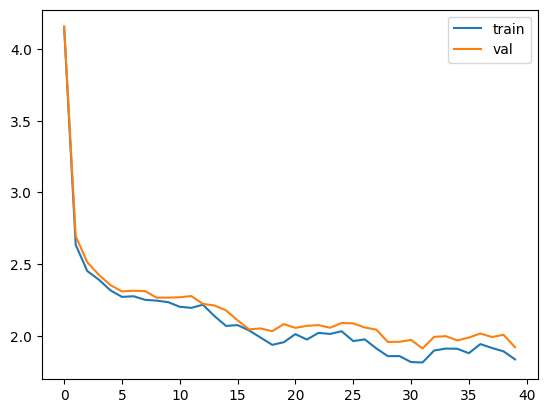

In [100]:
config = {
    "n_heads": 8,
    "d_model": 128,
    "batch_size": 32,
    "n_layers": 4,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 2000,
    "log_interval": 50,
}
model = Llama(config)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3,
    betas=(0.9, 0.95),
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 300, eta_min=1e-5)

losses = []
start_time = time.time()
for epoch in range(config['epochs']):
    optimizer.zero_grad()
    
    xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
    logits, loss = model(xs, targets=ys)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    
    if epoch % config['log_interval'] == 0:
        batch_time = time.time() - start_time
        x = evaluate_loss(model)
        losses += [x]
        print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
        start_time = time.time()

        print([decode(x) for x in model.generate(torch.zeros(5, 1).long()).tolist()])

pd.DataFrame(losses).plot()

In [104]:
import timeit

def generate(model, idx, max_length=30):
    x = idx
    with torch.no_grad():
        for _ in range(max_length):
            sequence = x[:, -model.config['context_window']:]
            logits = model(sequence)[:,-1, :]
            probs = F.softmax(logits, dim=-1)
            pred = torch.multinomial(probs, 1, replacement=True)
            x = torch.cat([x, pred], dim=-1)
        return x

%time [decode(x) for x in generate(model, torch.randint(0, len(vocab), (5, 1)).long()).tolist()]

CPU times: user 1.92 s, sys: 36.3 ms, total: 1.96 s
Wall time: 1.93 s


['Tog our have\nGod thou, you his ',
 't, bracknt:\nI say,\nHe bind if b',
 'k of bince pears\nMy cann to sit',
 'f\nIn love\nHENMY ONTEN:\nAnd I wh',
 'ice:\nHeave men\nHese with wash:\n']

In [110]:
%time [decode(x) for x in model.generate(torch.randint(0, len(vocab), (config['batch_size'], 1)).long(), 1000).tolist()]

CPU times: user 1min 39s, sys: 4.27 s, total: 1min 43s
Wall time: 1min 41s


["ors dancef,\nAnd grue in the hach that gave heaves more piit up so death; come majk\nThrick him?\n\nThe ounto lord, all of thirs kind! is with the cuesummand upyded for Clowle.\n\nYORK:\nHere you the prantrue wep, lord,\nI swirl'd will but stain,\nWhich save yould neviel this rethen: Sailibrodst him.\n\nNENENIUS:\nEve hir.\n\nPRIS:\nI shall of theere in colieving'shim?\n\nFROMEO:\nAnd your like we some which ta post to down monliest's I dongeral cosese! as munly thee is to a mother.\n\nAUFIul maken.\n\nLANDY ANNTE:\nPogode, I ssay fury! have we crounted on that efo;\nSaw's ince top rund; of hone rek semad for that's grace to I truancolakner's come shall a hour reforthery\nKe him in blord-awny.\n\nCLENE:\nNod wellld Sone for the bust med will a by the\nthis become frireman:\nWhich thou that deelres goom deveringfit is not as aburne to porter in him; I like and I that it endeats?\n\nIVIONIUS:\nNe muke.\n\n\nFRID:\nAwet thuy, aglly: For rEds,\nI live:\nEver any dome your take;\nEd whord

In [111]:
%time [decode(x) for x in model.generate(torch.randint(0, len(vocab), (1, 1)).long(), 1000).tolist()]

CPU times: user 1min 25s, sys: 1.36 s, total: 1min 27s
Wall time: 1min 26s


["ngerfiulto!\nBowner firve one two knot thee meen revanancuntermomight, I am love?\n\nLICIFSAR AURI:\nThere becaure slay:\nApon Rowas from not in the liys love\nTo hat stand deathenger'd\nFlief Sruould adry, of her, man:\nWho sty hupy son.\n\n\nMENENENES:\nThen hare what I depeak frieffore he:\nDith I liay?\n\nAUDWARD IV:\nScome wif wair their neem,\nA, not the cary, that his eveingt but umn bauting hatther are withs mecthinkty.\n\nCINIUS:\nWe 'that rewith's your lett freer force it yill lieth deself\nNumberle lies deadanst: at he love it fore yous'llizer: yet there fearths Hence, where gentuer bery the ness!\nNo, sail and lief Farth,\nI nem, of it I or are of the wofts that illl.\n\nCOMINIUS:\nShould maje eve our so the darrd,\nMy if his botet off then farthe! thate coursed.\n\nLORD:\nMy you, your when and for a gofolving in here tey, your my love of you win! I will to know-fear's all a intle wear sbrow.\n\nEverice tilf you'ld have besto, as guer in to daysuly he presut she'st him.\n